In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms
from torchvision.models import ResNet18_Weights
from torchvision.models import ResNet50_Weights
from torchvision.models import ResNet101_Weights
from torchvision.models import ResNet152_Weights
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

In [2]:
print(torch.cuda.is_available())
print(torch.__version__)

True
2.1.0+cu121


In [3]:
transforms_wt = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [4]:
orig_set = datasets.ImageFolder(
    root='./data/test_03',
    transform=transforms_wt
)
data, label = orig_set[100]
transform_test = T.ToPILImage()
plt.imshow(transform_test(data))


In [5]:
orig_set.classes

In [6]:
len(orig_set)

'C:\\Users\\Pirmin.000\\PycharmProjects\\IGP\\data\\tool_finder\\10_11_2023_21_05_33'

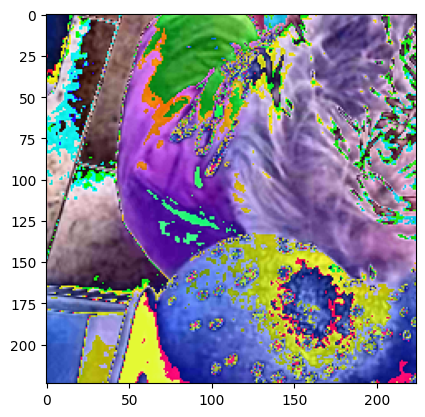

In [7]:
data, label = orig_set[0]
print(data.size())

In [8]:
import torch
from torch.utils.data import random_split, DataLoader

data_loader = DataLoader(orig_set, batch_size=len(orig_set), shuffle=True)

# Define the dataset size
dataset_size = len(orig_set)

# Calculate the sizes for training, validation, and test sets
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into training, validation, and test sets
train_set, val_set, test_set = random_split(orig_set, [train_size, val_size, test_size])

['duoballs', 'trigger']

In [9]:
val_data, val_label = val_set[1]
print(val_data.size())

4843

In [10]:
transform = T.ToPILImage()
plt.imshow(transform(val_data))

torch.Size([3, 224, 224])


In [11]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)

In [12]:
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)

torch.Size([3, 224, 224])


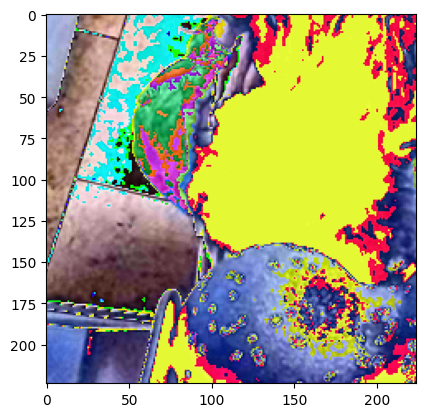

In [13]:
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)

In [14]:
model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

print(model.fc)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
print(model.fc)

In [16]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2048),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(1024,500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500,2)
)
#print(model.fc)

In [17]:
print(model)

Linear(in_features=2048, out_features=1000, bias=True)


In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
start_time = time.time()

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)/inputs.size(0)


    exp_lr_scheduler.step()
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() / inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)
    print(f"Epoch: {epoch}: Train: Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f} Val: Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

end_time = time.time()
print("Time:", end_time - start_time)

In [19]:
torch.save(model.state_dict(), "./trigger_duoballs_moddel_03.pt")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

test_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=4,
    shuffle=True,
    num_workers=16
)

In [ ]:
num_correct = 0.0
for inputs, labels in test_loader:
    model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    predict_label = model(inputs)
    _, predicted = torch.max(predict_label,1)
    num_correct += (predicted == labels).float().sum()

    accuracy = num_correct/(len(test_loader)*test_loader.batch_size)

    print(len(test_loader), test_loader.batch_size)
    print("Test Accuracy: {}".format(accuracy))

In [ ]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

def print_grid():
    inputs, classes = next(iter(test_loader))
    out = torchvision.utils.make_grid(inputs)
    class_names = orig_set.classes

    outputs = model(inputs.to(device))
    _, preds = torch.max(outputs, 1)

    imshow(out, title=[class_names[x] for x in preds])

print_grid()